# Trajectories analysis 3 (collective behaviour)
This notebook shows different analysis routines for trajectories of groups extracted with [idtracker.ai](idtracker.ai). If you use this code and/or data generated with [idtracker.ai](idtracker.ai), please cite:

**Romero-Ferrero, F., Bergomi, M.G., Hinz, R.C., Heras, F.J.H., de Polavieja, G.G., Nature Methods, 2019. idtracker.ai: tracking all individuals in small or large collectives of unmarked animals (F.R.-F. and M.G.B. contributed equally to this work. Correspondence should be addressed to G.G.d.P: gonzalo.polavieja@neuro.fchampalimaud.org)**

Some of the methods in this script are also available as part of a Matlab toolkit, idSocial (http://www.idtracker.es/idsocial) that was used and developed for the analysis of the article

**Hinz, R. C., & de Polavieja, G. G. (2017). Ontogeny of collective behavior reveals a simple attraction rule. Proceedings of the National Academy of Sciences, 201616926.** 

To load and analyse the trajectories we will be using the python library *trajectorytools*, you can install with `pip install trajectorytools`. If you use it, please cite:

**Heras, F. J. H., Romero-Ferrero, F., Hinz, R. C., & de Polavieja, G. G. (2019). Deep attention networks reveal the rules of collective motion in zebrafish. PLoS computational biology, 15(9), e1007354.**

## Importing necessary python modules for our analysis

In [82]:
from pprint import pprint
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import matplotlib.ticker as mtick
from matplotlib.axes import Axes

# trajectorytools needs to be installed. To install,
# pip install trajectorytools or follow the instructions at
# https://gitlab.com/polavieja_lab/trajectorytools
import trajectorytools as tt
import trajectorytools.socialcontext as ttsocial
from trajectorytools import Trajectories

## Load trajectories and setting parameters

Check the notebook T0_loading_idtrackerai_trajectories for more detailed instructions about loading idtracker.ai trajectories.

In [83]:
# Set path where to load trajectories from
trajectories_path = "../data/test_trajectories.npy"
tr = tt.Trajectories.from_idtrackerai(
    trajectories_path, interpolate_nans=True, smooth_params={"sigma": 1}
)
# Since the arena of the setup was circular and the fish visited the borders of the arena
# we use the estimate_center_and_radius_from_locations to center the trajectories
# in the arena
center, radius = tr.estimate_center_and_radius_from_locations(in_px=True)
tr.origin_to(center)
# In our case we know that the body_length_px is a good estimate for the body length
# since we loaded the trajectories with the method from_idtrackerai this value is
# stored in the tr.params disctionary
tr.new_length_unit(tr.params["body_length_px"], "BL")
# Since we loaded the trajectories with the method from_idtrackerai we can
# use the frame_rate variable stored in the tr.params disctioanry to
# to set the time units to seconds
print("Positions:")
print("X range:", np.nanmin(tr.s[..., 0]), np.nanmax(tr.s[..., 0]), "BL")
print("Y range:", np.nanmin(tr.s[..., 1]), np.nanmax(tr.s[..., 1]), "BL")
print("Velcities:")
print("X range:", np.nanmin(tr.v[..., 0]), np.nanmax(tr.v[..., 0]), "BL/s")
print("Y range:", np.nanmin(tr.v[..., 1]), np.nanmax(tr.v[..., 1]), "BL/s")
print("Accelerations:")
print("X range:", np.nanmin(tr.a[..., 0]), np.nanmax(tr.a[..., 0]), "BL/s^2")
print("Y range:", np.nanmin(tr.a[..., 1]), np.nanmax(tr.a[..., 1]), "BL/s^2")
pprint(tr.params)

Positions:
X range: -22.857960805634484 23.004886491518306 BL
Y range: -23.15551579252565 23.09623793320273 BL
Velcities:
X range: -0.7596434737145985 0.7950006518282955 BL/s
Y range: -0.8513883870094342 0.6596325996572823 BL/s
Accelerations:
X range: -0.5666745960720289 1.1746444912628775 BL/s^2
Y range: -0.366798301338635 0.338334734197512 BL/s^2
{'_center': array([1782.57651696, 1761.71033149]),
 'body_length_px': np.float64(69.0),
 'construct_method': 'from_idtrackerai',
 'displacement': array([-1782.57651696, -1761.71033149]),
 'frame_rate': 32,
 'interpolate_nans': True,
 'length_unit': np.float64(69.0),
 'length_unit_name': 'BL',
 'path': '../data/test_trajectories.npy',
 'radius': np.float64(23.18884521417357),
 'radius_px': np.float64(1600.0303197779763),
 'smooth_params': {'sigma': 1},
 'time_unit': 1,
 'time_unit_name': 'frames'}


## Global group behavior

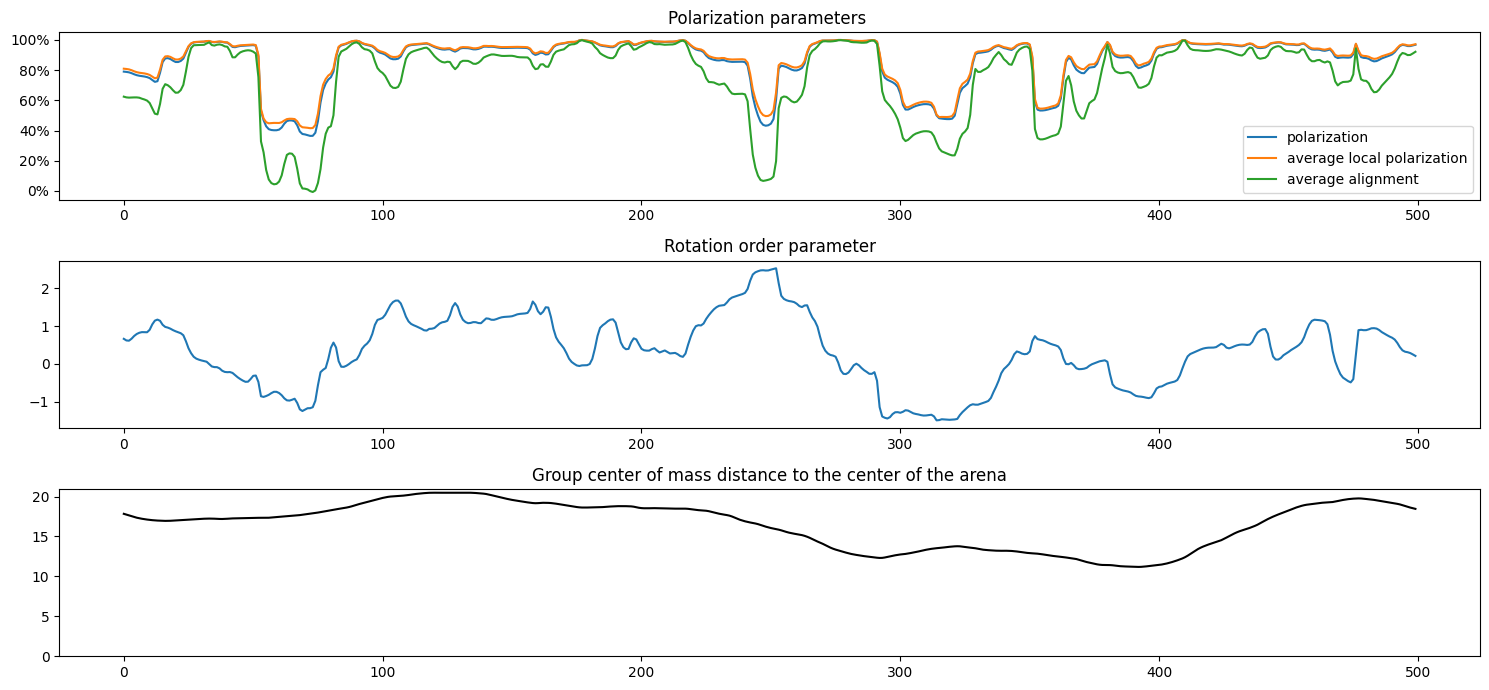

In [84]:
def get_local_polarization(t: Trajectories, number_of_neighbours=3):
    """The local polarization takes into account the neighbors of
    the focal animal and computes their polarization. It's not about the
    behavior of the focal but about its environment"""
    # [..., 1:, :] removes the closest neighbor, which is the focal animal itself
    indices = ttsocial.neighbour_indices(t.s, number_of_neighbours)[..., 1:]
    en = ttsocial.restrict(t.e, indices)
    return tt.collective.polarization(en)


def get_average_local_polarization(t: Trajectories, number_of_neighbours=3):
    "Averages the norm of the local polarizations"
    local_polarization = get_local_polarization(t, number_of_neighbours)
    return np.nanmean(tt.norm(local_polarization), axis=-1)


def get_local_aligment_scores(t: Trajectories, number_of_neighbours=3):
    """The local alignment score tells how aligned is the focal animal with
    respect to its local polarization, this is the polarization of its neighbors"""
    local_polarization = get_local_polarization(t, number_of_neighbours)
    return tt.dot(t.e, local_polarization)


t = tr[0:500]
polarization_order_parameter = tt.norm(tt.collective.polarization(t.e))
average_local_polarization = get_average_local_polarization(t)
average_alignment = np.nanmedian(get_local_aligment_scores(t), axis=-1)
fig, axs = plt.subplots(3, 1, figsize=(15, 7))


axs[0].set_title("Polarization parameters ")
axs[0].plot(polarization_order_parameter, label="polarization")
axs[0].plot(average_local_polarization, label="average local polarization")
axs[0].plot(average_alignment, label="average alignment")
axs[0].yaxis.set_major_formatter(mtick.PercentFormatter(1))
axs[0].legend()

axs[1].set(title="Rotation order parameter")
rotation_order_parameter = (
    tt.collective.angular_momentum(t.e, t.s, center=t.center_of_mass.s)
    / t.number_of_individuals
)
axs[1].plot(rotation_order_parameter)

axs[2].plot(t.center_of_mass.distance_to_origin, color="k")
axs[2].set(
    title="Group center of mass distance to the center of the arena", ylim=(0, None)
)
fig.tight_layout()

[Text(0.5, 0, 'Rotation order parameter'),
 Text(0, 0.5, 'Polarization order parameter')]

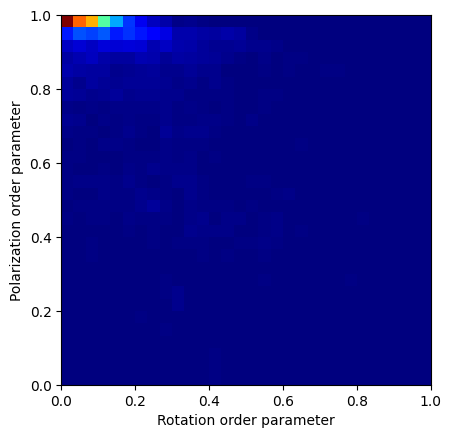

In [85]:
t = tr[0:10000]
polarization_order_parameter = tt.norm(tt.collective.polarization(t.e))
rotation_order_parameter = (
    tt.collective.angular_momentum(t.e, t.s, center=t.center_of_mass.s)
    / t.number_of_individuals
)
fig, ax = plt.subplots(1)
H, _, _ = np.histogram2d(
    polarization_order_parameter[~np.isnan(polarization_order_parameter)],
    np.abs(rotation_order_parameter[~np.isnan(polarization_order_parameter)]),
    bins=(30, 30),
)
im = ax.imshow(H, cmap="jet", extent=(0, 1, 1, 0))
ax.invert_yaxis()
ax.set(xlabel="Rotation order parameter", ylabel="Polarization order parameter")

## Relative neighbour positions

In a coordinate system in which the focal individual is at the center and moving in direction of the positive y-axis, we can analyse the probability of finding neighbors at certain relative positions, and how the focal individual reacts in terms of left/right turns and increase/decrease in speed. 


In [86]:
# Rotate neighbor positions and acceleration vectors to the focal system:
s_rotated = np.empty(
    (tr.number_of_frames, tr.number_of_individuals, tr.number_of_individuals, 2)
)
a_rotated = tt.fixed_to_comoving(tr.a, tr.e)

for focal in range(tr.number_of_individuals):
    s = tt.center_in_individual(tr.s, focal)
    sr = tt.fixed_to_comoving(s, tr.e[:, focal, :])
    # Change rotated positions of the focal itself from '0' to 'NaN'.
    sr[:, focal] = np.nan
    s_rotated[:, focal, :, :] = sr
    # Rotate the focal's
    # acceleration vector. The x-component of the rotated vector contains the acceleration perpendicular to the
    # focal's direction of movement ('turning'), the parallel component contains the increase/decrease of speed.
    a_rotated[:, focal, :] = tt.fixed_to_comoving(tr.a[:, focal], tr.e[:, focal])

# Pool together relative neighbor positions and focal acceleration vectors
sr_flat = s_rotated.reshape((-1, 1, 2))
ar_flat = np.repeat(
    a_rotated[:, :, np.newaxis, :], tr.number_of_individuals, 2
).reshape((-1, 1, 2))

### 2D-Histogram, all focal-neighbour pairs pooled together 

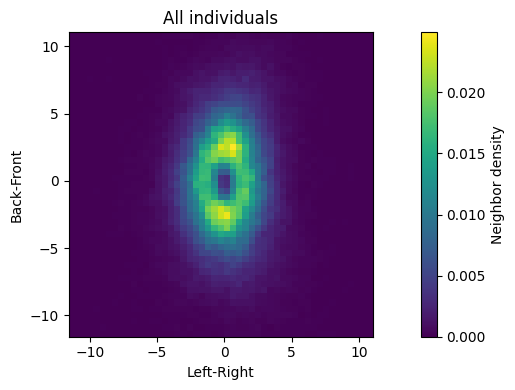

In [87]:
# Define bin edges: (left/bottom limit, right/top limit, bin width)
h_min = np.min([np.nanmin(tr.s[..., 0]) / 2, np.nanmin(tr.s[..., 1]) / 2])
h_max = np.min([np.nanmax(tr.s[..., 0]) / 2, np.nanmax(tr.s[..., 1]) / 2])
bin_size = (h_max - h_min) / 50
bins = [np.arange(h_min, h_max, bin_size), np.arange(h_min, h_max, bin_size)]
x = sr_flat[:, 0, 0]
y = sr_flat[:, 0, 1]

# Clean data from 'Nans'
y = y[~np.isnan(x)]
x = x[~np.isnan(x)]

# Plot the histogram
# x and y are switched to comply with np.histogram2d convention
H, yedges, xedges = np.histogram2d(y, x, bins=bins, density=True)
Y, X = np.meshgrid(yedges, xedges)
fig, ax_meanposmap = plt.subplots(figsize=(10, 4))
im = ax_meanposmap.pcolormesh(Y, X, H)

# Add colorbar, labels, etc.
ax_cb = fig.colorbar(im, ax=ax_meanposmap)
ax_meanposmap.set(
    aspect="equal", title="All individuals", xlabel="Left-Right", ylabel="Back-Front"
)
ax_cb.set_label("Neighbor density")
fig.tight_layout()

## Polar 2D-histograms and maps of turning and acceleration maps depending on neighbor positions

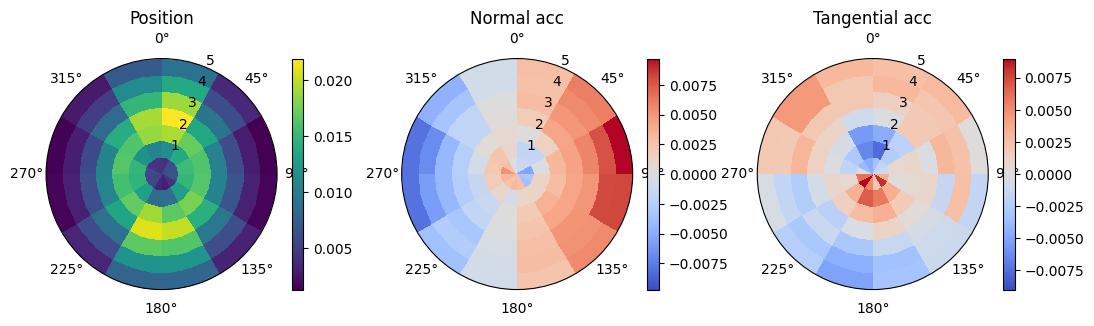

In [88]:
from trajectorytools.plot import (
    polar_histogram,
    binned_statistic_polar,
    plot_polar_histogram,
)

map_value = ar_flat[:, 0, :]
x = sr_flat[:, 0, 0]
y = sr_flat[:, 0, 1]

r = np.sqrt(x**2 + y**2)
# angles increase clockwise, and are zero in the positive y axis
theta = np.arctan2(x, y)

pos_hist, r_edges, theta_edges = polar_histogram(r, theta, density=True, range_r=5)
Turn = binned_statistic_polar(
    r, theta, map_value[:, 0], statistic=np.nanmean, range_r=5
)
turn_stats = Turn.statistic

Fwd = binned_statistic_polar(r, theta, map_value[:, 1], statistic=np.nanmean, range_r=5)
fwd_stats = Fwd.statistic

figure(num=None, figsize=(13, 3), facecolor="w", edgecolor="k")
# Plot polar histogram/maps for relative neighbor positions, turning and acceleration

ax = plt.subplot(131, polar=True)
plot_polar_histogram(pos_hist, r_edges, theta_edges, ax)
ax.set(title="Position")

ax = plt.subplot(132, polar=True)
plot_polar_histogram(
    turn_stats, r_edges, theta_edges, ax, cmap="coolwarm", symmetric_color_limits=True
)
ax.set(title="Normal acc")

ax = plt.subplot(133, polar=True)
plot_polar_histogram(
    fwd_stats, r_edges, theta_edges, ax, cmap="coolwarm", symmetric_color_limits=True
)

ax.set(title="Tangential acc")
fig.tight_layout()

## Inter-Individual Distances

### Calculate interindividual distances

In [89]:
def interindividual_distance(trajectories) -> np.ndarray:
    """Computes the pairwise distances of all possible pairs of animals"""
    distances_matrix = ttsocial.adjacency_matrix(trajectories, mode="distance")
    for i in range(distances_matrix.shape[1]):
        distances_matrix[:, i, i] = np.nan
    return distances_matrix


distances = interindividual_distance(tr.s).reshape((-1, tr.number_of_individuals))

### Generate shuffled trajectories and control distances

In [90]:
def shuffle_trajectories(trajectories: np.ndarray, focal: int):
    num_fish = trajectories.shape[1]
    neighbor_idces = [i for i in range(num_fish) if i != focal]
    # print(neighbor_idces)
    t_shuffle = trajectories.copy()
    t_shuffle[:, neighbor_idces] = np.random.permutation(t_shuffle[:, neighbor_idces])
    return t_shuffle


def distance_to_focal(trajectories: np.ndarray, focal: int):
    distances = np.sqrt(
        np.sum(
            (trajectories[:, [focal]] - np.delete(trajectories, focal, axis=1)) ** 2,
            axis=2,
        )
    )
    return distances  # np.delete(distances, focal, axis=1)


# Calculate control data: For each focal individual, shuffle the neighbor positions, then
# calculate the distance between the original focal positions and the randomized neighbor positions.
distances_shuffled = np.empty(
    (tr.number_of_frames * (tr.number_of_individuals - 1), tr.number_of_individuals)
)
for focal in range(tr.number_of_individuals):
    t_shuffle = shuffle_trajectories(tr.s, focal)
    d_ = distance_to_focal(t_shuffle, focal)
    # Pool all neighbor distances for 'focal'
    distances_shuffled[:, focal] = d_[:, :].reshape(-1)

### Plot distance histograms

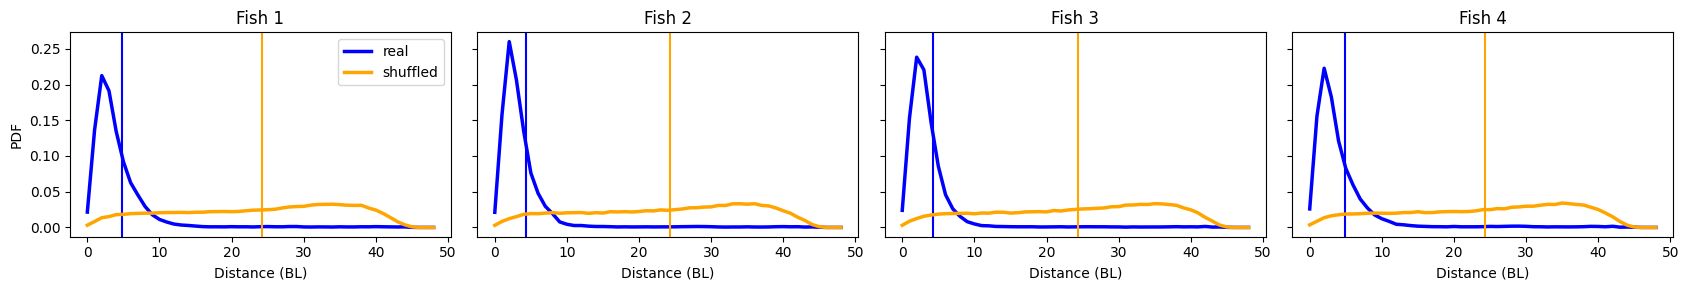

In [91]:
# Mean inter-individual distance to all neighbor animals for each focal.


def plot_histogram_and_mean(data, ax: Axes, color="r", label="") -> None:
    nbins = np.arange(0, 50, 1)
    d_mean = np.mean(data)
    hist = np.histogram(data, nbins, density=True)
    ax.plot(nbins[:-1], hist[0], linewidth=2.5, color=color, label=label)
    ax.axvline(x=d_mean, color=color)


fig, ax_hist = plt.subplots(1, tr.number_of_individuals, figsize=(17, 3), sharey=True)

for ax, focal in zip(ax_hist, range(tr.number_of_individuals)):
    # Get rid of "NaNs":
    data = distances[:, focal]
    data = data[~np.isnan(data)]

    plot_histogram_and_mean(data, ax, color="b", label="real")
    plot_histogram_and_mean(
        distances_shuffled[:, focal], ax, color="orange", label="shuffled"
    )

    # Some design parameters

    ax.set(title=f"Fish {focal + 1}", xlabel="Distance (BL)")

ax_hist[0].set(ylabel="PDF")

plt.subplots_adjust(wspace=0.3, hspace=0.3)
ax_hist[0].legend()
fig.tight_layout()